# Libraries

In [ ]:
import cv2 as cv
import numpy as np
import os
import time
from google.colab.patches import cv2_imshow as imshow
from IPython.display import clear_output as clear
import pandas as pd
from imutils.object_detection import non_max_suppression
import math
import imutils

#Testing

In [ ]:
sample = cv.imread('Inked Sample 02.jpg')

In [ ]:
threshold = 600

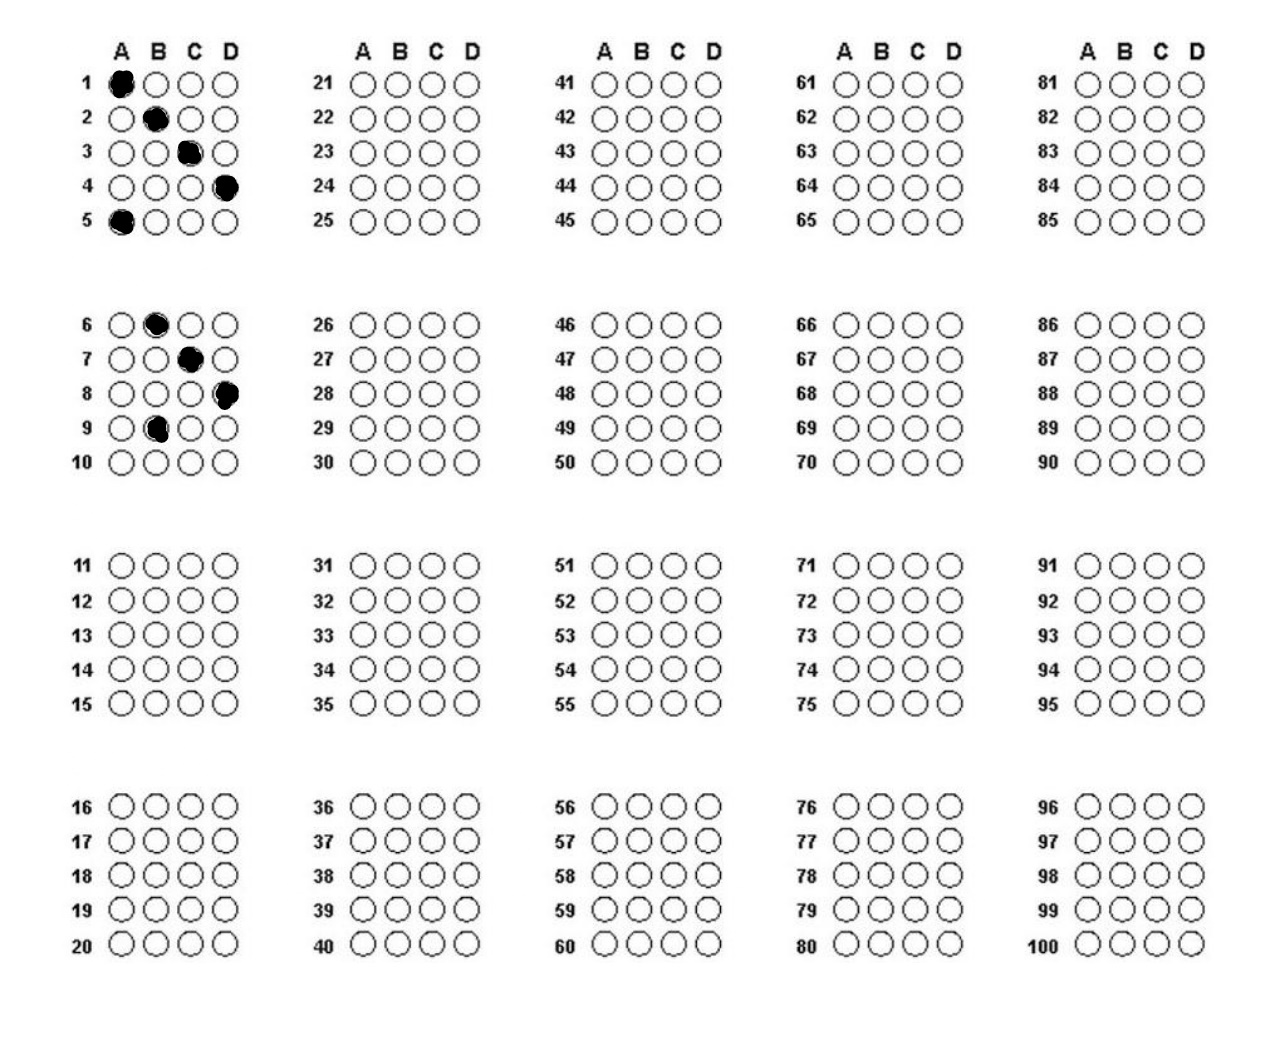

In [ ]:
extract = sample[threshold:, :]
imshow(extract)

#Manipulation

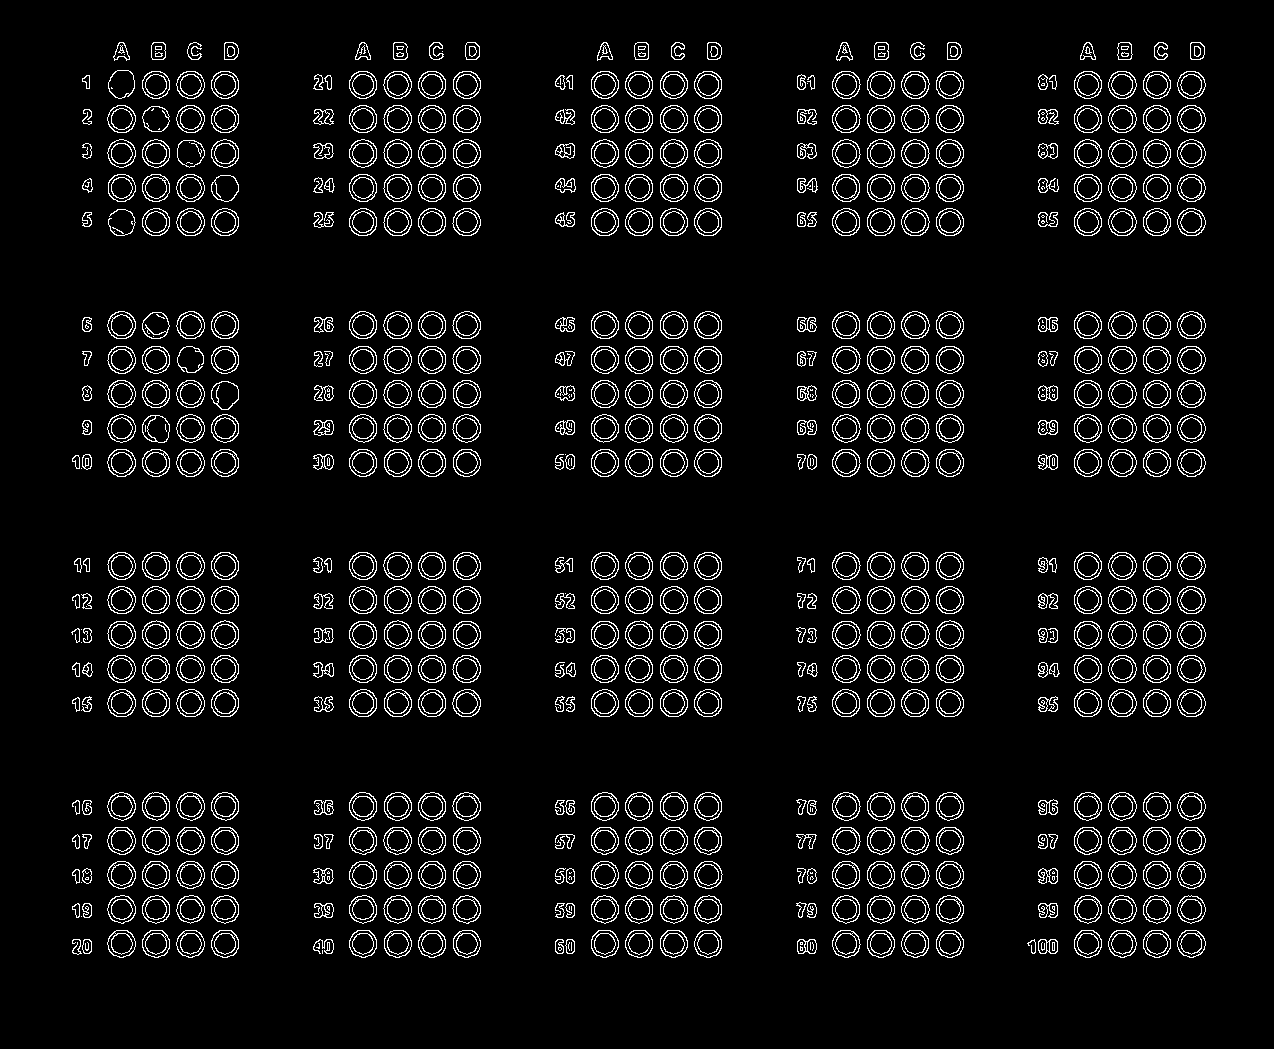

In [ ]:
gray1 = cv.cvtColor(extract, cv.COLOR_BGR2GRAY)
blurred1 = cv.GaussianBlur(gray1, (5, 5), 0)
edges = cv.Canny(blurred1, 50, 100)
imshow(edges)

In [ ]:
contours, hierarchy = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

In [ ]:
for contour in contours:

  boundingCoords = cv.boundingRect(contour)
  print(type(boundingCoords), boundingCoords)
  break

<class 'tuple'> (322, 950, 1, 4)


In [ ]:
boundingRectangles = [cv.boundingRect(contour) for contour in contours]
len(boundingRectangles)

597

In [ ]:
data = []
optionPositions = []

In [ ]:
drawing = extract
i = 0

for x, y, w, h in boundingRectangles[::-1]:

  i += 1
  if abs(w - 28) <= 2 and abs(h - 28) <= 2:
    print('Iteration {}'.format(i))
    print('Box height = {} width = {}'.format(h, w), x, y)
    drawing = cv.rectangle(drawing, (x, y), (x+w, y+h), (110, 64, 26), 1)
    imshow(drawing)
    time.sleep(0.1)
    clear()

In [ ]:
drawing = extract
i = 0
counter = 0

for x, y, w, h in boundingRectangles[::-1]:

  i += 1
  if abs(w - 28) <= 2 and abs(h - 28) <= 2:
    counter += 1
    print('Iteration {}'.format(i))
    print('Box height = {} width = {}'.format(h, w), x, y)
    drawing = cv.rectangle(drawing, (x, y), (x+w, y+h), (110, 64, 26), 1)
    optionPositions.append([x, y, w, h])
    
    if counter % 4 == 0:

      data.append(optionPositions)
      print('Appending')
      optionPositions = []

  else:
    print('Skipping Iteration {}'.format(i))

  print('\n\n\n\n')

imshow(drawing)

In [ ]:
len(data)

100

In [ ]:
opted = []

In [ ]:
for x, y, w, h in data[9]:

  print(np.mean(extract[y:y+h, x:x+w]))

201.3415435139573
200.04931972789115
201.3107553366174
67.53205128205128


In [ ]:
for optionBank in data:
  counter = -1
  for x, y, w, h in optionBank:
    counter += 1
    xMean = np.mean(extract[y:y+h, x:x+w])
    if abs(xMean - 60)  <= 5.00:
      opted.append(['A', 'B', 'C', 'D'][counter])
      break
    if counter == 3:
      opted.append('Null')

# Template Match Testing

In [ ]:
sample = cv.imread('NTSE Mock Test Sample.jpg')
lineOfDiscretion = cv.imread('Line Of Discretion.jpg')
questions = cv.imread('Questions.jpg')

In [ ]:
method = cv.TM_SQDIFF_NORMED

In [ ]:
matches = cv.matchTemplate(sample, lineOfDiscretion, method)

In [ ]:
mn, __, mnLoc, __ = cv.minMaxLoc(matches)

In [ ]:
x, y = mnLoc

In [ ]:
print(x, y)

229 569


In [ ]:
w, h = lineOfDiscretion.shape[:2]

In [ ]:
print(w, h)

100 815


In [ ]:
cv.rectangle(sample, (x, y), (x+h, y+w), (255, 0, 0), 2) 

In [ ]:
imshow(sample)

# Pipeline

In [ ]:
def eagleVision(paper, kernelSize=5, debug=True):

  resizedPaper = cv.resize(paper.copy(), (1275, 1650), interpolation=cv.INTER_AREA)

  grayed = cv.cvtColor(resizedPaper, cv.COLOR_BGR2GRAY)
  blurred = cv.GaussianBlur(grayed, (kernelSize, kernelSize), 0)
  edged = cv.Canny(blurred, 75, 200)
  contours, hierarchy = cv.findContours(edged, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
  cnts = cv.findContours(edged, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

  boundingBoxes = [cv.boundingRect(shape) for shape in contours]
  boundingBoxes = [[x, y, x+w, y+h] for x, y, w, h in boundingBoxes]

  boundingBoxes = non_max_suppression(np.array(boundingBoxes))
  analysis = resizedPaper.copy()

  if debug: imshow(edged)
  print('\n\n\n\n\n')

  for x1, y1, x2, y2 in boundingBoxes:

    cv.rectangle(analysis, (x1, y1), (x2, y2), (255, 0, 0), 2)

  cnts = imutils.grab_contours(cnts)
  docCnt = None

  if len(cnts):

    cnts = sorted(cnts, key=cv.contourArea, reverse=True)
    for cnt in cnts:

      peri = cv.arcLength(cnt, True)
      approx = cv.approxPolyDP(cnt, 0.02 * peri, True)

      if len(approx) == 4:
        docCnt = approx
        break

  docCnt = docCnt.reshape(4, 2)
  
  for x, y in list(docCnt):

    cv.circle(analysis, (x, y), 4, (0, 255, 0), -1)

  if debug: imshow(analysis)

  paper = four_point_transform(resizedPaper, docCnt)
  warped = four_point_transform(grayed, docCnt)

  thresh = cv.threshold(warped, 0, 255,
    cv.THRESH_BINARY | cv.THRESH_OTSU)[1]

  thresh = cv.resize(thresh, (1275, 1650), interpolation=cv.INTER_AREA)
  return thresh


In [ ]:
def order_points(pts):
	rect = np.zeros((4, 2), dtype = "float32")
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	return rect

In [ ]:
def four_point_transform(image, pts):
  
  rect = order_points(pts)
  tl, tr, br, bl = rect

  widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
  widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
  maxWidth = max(int(widthA), int(widthB))

  heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
  heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
  maxHeight = max(int(heightA), int(heightB))

  dst = np.array([
    [0, 0],
    [maxWidth - 1, 0],
    [maxWidth - 1, maxHeight - 1],
    [0, maxHeight - 1]], dtype = "float32")

  M = cv.getPerspectiveTransform(rect, dst)
  warped = cv.warpPerspective(image, M, (maxWidth, maxHeight))

  return warped

In [ ]:
def findPivotsAndRotate(paper, pivotTemplate, threshold=0.8, debug=False):

  rotationPivots = cv.matchTemplate(paper, pivotTemplate, cv.TM_CCOEFF_NORMED)

  
  Y, X = np.where(rotationPivots >= threshold)
  tH, tW = pivotTemplate.shape[:2]
  boxes = []

  for x, y in zip(X, Y):

    boxes.append([x, y, x + tW, y + tH])

  suppressedBoxes = non_max_suppression(np.array(boxes))

  if len(suppressedBoxes) != 2:

    print('Error 501: Pivot Overload...\nNumber Of Pivots: {}'.format(len(suppressedBoxes)))
    return -1

  pivot1, pivot2 = [((x1+x2)/2, (y1+y2)/2) for x1, y1, x2, y2 in suppressedBoxes]

  if pivot1[0] > pivot2[0]:

    pivot1, pivot2 = pivot2, pivot1

  if debug:

    print('Pivot 1: {}'.format(pivot1))
    print('Pivot 2: {}'.format(pivot2))

  p = abs(pivot1[1] - pivot2[1])
  b = abs(pivot1[0] - pivot2[0])
  
  if pivot2[1] < pivot1[1]:

    commutator = -1

  elif pivot2[1] > pivot1[1]:

    commutator = 1

  else:

    commutator = 0

  quaternionAngle = math.atan(p/b)*180/math.pi
  quaternionAngle *= commutator
  if debug: print('Angle to translate by: {}'.format(quaternionAngle))

  h, w = paper.shape[:2]
  center = (w/2, h/2)
  scale = 1

  matrix = cv.getRotationMatrix2D(center, quaternionAngle, scale)
  perfectPaper = cv.warpAffine(paper, matrix, (w, h))

  if debug:

    imshow(perfectPaper)

  return perfectPaper


In [ ]:
def centralizePaper(paper, pivotTemplate, threshold, debug=False):

  rotationPivots = cv.matchTemplate(paper, pivotTemplate, cv.TM_CCOEFF_NORMED)
  h, w = paper.shape[:2]

  Y, X = np.where(rotationPivots >= threshold)
  tH, tW = pivotTemplate.shape[:2]
  boxes = []

  for x, y in zip(X, Y):

    boxes.append([x, y, x + tW, y + tH])

  suppressedBoxes = non_max_suppression(np.array(boxes))

  pivot1, pivot2 = [((x1+x2)/2, (y1+y2)/2) for x1, y1, x2, y2 in suppressedBoxes]

  if pivot1[0] > pivot2[0]:

    pivot1, pivot2 = pivot2, pivot1

  diff = pivot1[0] - 49.5
  paddedPaper = None

  if debug:

    print('Pivot 1: {}\nPivot 2: {}'.format(pivot1, pivot2))
    print('Diff: {}'.format(diff))

  if diff != 0:

    if diff < 0:

      if debug: print('Add Left Margin And Crop Right Margin', int(w+diff))

      paper = paper[:, :int(w+diff)]
      paddedPaper = cv.copyMakeBorder(paper, 0, 0, abs(int(diff)), 0, cv.BORDER_CONSTANT, value=(255, 255, 255))

    else:

      if debug: print('Add Right Margin And Crop Left Margin')

      paper = paper[:, int(diff):]
      paddedPaper = cv.copyMakeBorder(paper, 0, 0, 0, int(diff), cv.BORDER_CONSTANT, value=(255, 255, 255))

  else:

    paddedPaper = paper

  if debug and diff:

    imshow(paddedPaper)

  rotationPivots = cv.matchTemplate(paddedPaper, pivotTemplate, cv.TM_CCOEFF_NORMED)
  Y, X = np.where(rotationPivots >= threshold)

  boxes = []

  for x, y in zip(X, Y):

    boxes.append([x, y, x + tW, y + tH])

  suppressedBoxes = non_max_suppression(np.array(boxes))
  pivot1, pivot2 = [(x1, y1, x2, y2) for x1, y1, x2, y2 in suppressedBoxes]

  if pivot1[0] > pivot2[0]:

    pivot1, pivot2 = pivot2, pivot1


  return paddedPaper, int(pivot1[0]), int(pivot2[2])

In [ ]:
def cropToMarkedRegion(paper, lineOfDiscretion, method):

  matches = cv.matchTemplate(paper, lineOfDiscretion, method)
  mn, __, location, ___ = cv.minMaxLoc(matches)

  x, y = location

  h, w = lineOfDiscretion.shape[:2]

  return paper[y+h:, :]

In [ ]:
from IPython.core.display import clear_output
def findTents(paper):

  xTent, yTent = 0, 0

  while True:

    yTent, xTent = map(int, input('Analysation stand by for.... y: x:').split())

    hypothesis = paper.copy()
    h, w = hypothesis.shape[:2]
    for i in range(w//xTent + 1):
      cv.line(hypothesis, (i*xTent, 0), (i*xTent, h), (0, 0, 0), 2)
    for i in range(h//yTent + 1):
      cv.line(hypothesis, (0, i*yTent), (w, i*yTent), (0, 0, 0), 2)

    print('Hypothesis...')
    imshow(hypothesis)
    time.sleep(2.5)
    command = int(input('Command to iterate...'))

    if command == -1:
      break


  print('\n\n\n\n\n\n\n\n')
  return yTent, xTent

In [ ]:
def divideIntoBlocks(paper, custom=False):

  xTent = 225
  yTent = 245

  if custom: yTent, xTent = findTents(paper)

  blocks = []

  for i in range(5):

    questionsCol = paper[:, xTent*i:xTent*(i+1)]

    for j in range(4):

      block = questionsCol[j*yTent:(j+1)*yTent, :]
      blocks.append(block)
                            
  return blocks

In [ ]:
def findAllShapes(paper, kernelSize):

  #gray = cv.cvtColor(paper, cv.COLOR_BGR2GRAY)
  blurred = cv.GaussianBlur(paper, (kernelSize, kernelSize), 0).astype(np.uint8)
  #print(blurred.shape, blurred.dtype)
  edges = cv.Canny(blurred, 75, 200)
  
  contours, hierarchy = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

  return contours

In [ ]:
def filterOptionLocs(block, boundingRectangles, data, meanPixel, tolerationFactor=50.0, debug=False):

  i = 0
  counter = 0
  optionSet = []

  for x, y, x2, y2 in boundingRectangles[::-1]:

    w = x2-x
    h = y2-y
    i += 1

    if w >= 25 and h >= 25:

      counter += 1

      if debug:
        print('Iteration {}'.format(i))
        print('Box height = {} width = {}'.format(h, w), x, y)
        print('Mean Pixel: {}'.format(meanPixel))

      optionSet.append([x, y, w, h])
      
      if debug:
        print('\n\n\n\n')
        cv.rectangle(block, (x, y), (x+w, y+h), (0, 0, 0), 1)
        #imshow(block)

      if counter % 4 == 0:

        optionSet = sorted(optionSet, key=lambda k: (2*k[0]+k[2]/2))
        answer = ''
        opCount = -1

        for x, y, w, h in optionSet:

          opCount += 1
          regionMean = np.mean(block[y:y+h, x:x+w])

          if debug:
            print('Regie Meanie', regionMean, opCount, i, 'Centroid', (2*x+w)/2, (2*y+h)/2)

          if abs(regionMean - meanPixel)  >= tolerationFactor:

            print('RegionMean: {} Mean Pixel: {} TolerationFactor: {}'.format(regionMean, meanPixel, tolerationFactor))
            answer  += ['A', 'B', 'C', 'D'][opCount]

          if opCount == 3 and answer == '':

            answer = 'Null'

        optionSet.append(answer)

        if debug:
          print('All Option Data: ', optionSet)

        data.append(optionSet)

        if debug:
          print('Appending', i)

        optionSet = []
        counter = 0

    else:

      if debug:
        print('Skipping Iteration {} for w={}, h={}'.format(i, w, h))
        cv.rectangle(block, (x, y), (x2, y2), (0, 255, 0), 2)


  return data

In [ ]:
def filterOptionLocs(block, boundingRectangles, data, meanPixel, tolerationFactor=50.0, debug=False):

  i = 0
  counter = 0
  optionSet = []
  skipped = []

  for x, y, x2, y2 in boundingRectangles[::-1]:

    w = x2-x
    h = y2-y
    i += 1
    if debug:
      print('Aspect Ratio: {}'.format(w/float(h)))

    if w >= 20 and h >= 20:

      counter += 1

      if debug:
        print('Iteration {}'.format(i))
        print('Box height = {} width = {}'.format(h, w), x, y)
        print('Mean Pixel: {}'.format(meanPixel))
        

      optionSet.append([x, y, w, h])
      
      if debug:
        print('\n\n\n\n')
        #cv.rectangle(block, (x, y), (x+w, y+h), (0, 0, 0), 1)
        #imshow(block)

      if counter % 4 == 0:

        optionSet = sorted(optionSet, key=lambda k: (2*k[0]+k[2]/2))
        answer = ''
        opCount = -1

        for x, y, w, h in optionSet:

          opCount += 1
          regionMean = np.mean(block[y:y+h, x:x+w])

          if debug:
            print('Regie Meanie', regionMean, opCount, i, 'Centroid', (2*x+w)/2, (2*y+h)/2)

          if abs(regionMean - meanPixel)  >= tolerationFactor:

            if debug: print('RegionMean: {} Mean Pixel: {} TolerationFactor: {}'.format(regionMean, meanPixel, tolerationFactor))
            answer  += ['A', 'B', 'C', 'D'][opCount]

          if opCount == 3 and answer == '':

            answer = 'Null'

        optionSet.append(answer)

        if debug:
          print('All Option Data: ', optionSet)

        data.append(optionSet)

        if debug:
          print('Appending', i)

        optionSet = []
        counter = 0

    else:

      if debug:
        print('Skipping Iteration {} for w={}, h={}'.format(i, w, h))
        #cv.rectangle(block, (x, y), (x2, y2), (0, 255, 0), 2)
        imshow(block)

      #skipped.append([x, y, w, h])

  return data

In [ ]:
def extractData(blocks, tolerationFactor=50.0, debug=False):

  data = []
  optionSet = []

  for block in blocks:

    meanPixel = np.mean(block[:2, :2])

    shapes = findAllShapes(block, 5)
    boundingBoxes = [cv.boundingRect(shape) for shape in shapes]
    boundingBoxes = [[x, y, x+w, y+h] for x, y, w, h in boundingBoxes]

    boundingBoxes = non_max_suppression(np.array(boundingBoxes))
    
    """for x, y, w, h in boundingBoxes:

      cv.rectangle(block, (x, y), (x+w, y+h), (110, 64, 26), 1)

    imshow(block)"""

    filterOptionLocs(block, boundingBoxes, data, meanPixel, tolerationFactor, debug)

    if debug: imshow(block)
    print('\n\n\n\n')

  return data

In [ ]:
def checkAnswers(marked, answers):

  score = 0
  wrong = {}

  if len(marked) != len(answers):

    print("Answers don't match.\nMarked Questions: {}\nQuestions With Answers: {}".format(len(marked), len(answers)))
    return (-1, None, None)

  i = 0
  for m, a in zip(marked, answers):

    i += 1

    if a == 'Bonus':

      score += 1
      continue

    if m == a and m != 'Null':

      score += 1

    else:

      wrong[i] = [m, a]

  return (0, score, wrong)

In [ ]:
inkedPaper = cv.imread('World Sample 5.jpg', cv.COLOR_BGR2GRAY)
lineOfDiscretion = cv.imread('Line Of Discretion.jpg', cv.IMREAD_GRAYSCALE)
coolLine = lineOfDiscretion[70:-15, :].astype(np.float32)
pivoters = cv.imread('Rotation Pivot.jpg', cv.IMREAD_GRAYSCALE).astype(np.float32)
anchorPoints = cv.imread('Anchors.png')
method = cv.TM_SQDIFF_NORMED

In [ ]:
threshed = eagleVision(inkedPaper, 5)

In [ ]:
imshow(threshed)

In [ ]:
resizedPaper = cv.resize(inkedPaper.copy(), (1275, 1650), interpolation=cv.INTER_AREA)

In [ ]:
resizedPaper = cv.cvtColor(resizedPaper, cv.COLOR_BGR2GRAY)

In [ ]:
imshow(resizedPaper)

In [ ]:
pivotedPaper = findPivotsAndRotate(resizedPaper.astype(np.float32), pivoters, 0.84, False)

In [ ]:
imshow(pivotedPaper)

In [ ]:
translatedPaper, x1, x2 = centralizePaper(pivotedPaper, pivoters, 0.84, False)

In [ ]:
imshow(translatedPaper)

In [ ]:
translatedPaper = translatedPaper[:, x1:x2]

In [ ]:
extract = cropToMarkedRegion(translatedPaper.copy(), coolLine, method)

In [ ]:
imshow(extract)

In [ ]:
blocks = divideIntoBlocks(extract, True)

In [ ]:
data = extractData(blocks, 100.0, False)

In [ ]:
for i, option in enumerate(data):

  print('{}: {}'.format(i+1, option[4]))

In [ ]:
markedAnswers = [answer[4] for answer in data]

In [ ]:
answerKey = pd.read_excel('./Answer Key.xlsx', 0, 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Starting with pandas version 2.0 all arguments of read_excel except for the arguments 'io' and 'sheet_name' will be keyword-only
  """Entry point for launching an IPython kernel.


In [ ]:
for i, answer in enumerate(answerKey['Answer']):

  print('{}: {}'.format(i+1, answer))

In [ ]:
status, score, wrong = checkAnswers(markedAnswers, answerKey['Answer'])

In [ ]:
score

96

In [ ]:
wrong

{7: ['Null', 'Null'],
 10: ['A', 'Null'],
 11: ['CD', 'BD'],
 54: ['Null', 'Null']}

# **Dia**

In [ ]:
def Check(answerSheet, discreteLine, pivoter, anchor, keyPath, method, gaussionEffect=5, safetyFactor=100.00):

  print('Analysing...')
  #threshed = eagleVision(inkedPaper, 1, True)
  threshed = cv.resize(inkedPaper.copy(), (1275, 1650), interpolation=cv.INTER_AREA)
  threshed = cv.cvtColor(threshed, cv.COLOR_BGR2GRAY)
  pivotedPaper = findPivotsAndRotate(threshed.astype(np.float32), pivoter, 0.84, False)
  translatedPaper, x1, x2 = centralizePaper(pivotedPaper, pivoters, 0.84, False)
  translatedPaper = translatedPaper[:, x1:x2]

  extract = cropToMarkedRegion(translatedPaper.copy(), coolLine, method)
  blocks = divideIntoBlocks(extract, True)

  data = extractData(blocks, safetyFactor, False)

  print('\n\nAnswers')
  for i, option in enumerate(data):

    print('{}: {}'.format(i+1, option[4]))

  markedAnswers = [answer[4] for answer in data]

  answerKey = pd.read_excel(keyPath, 0, 0)

  print('\n\nKey')
  for i, answer in enumerate(answerKey['Answer']):

    print('{}: {}'.format(i+1, answer))

  status, score, wrong = checkAnswers(markedAnswers, answerKey['Answer'])
  print('\n\nScore: {}'.format(score))
  
  for key in wrong.keys():

    answer, marked = wrong[key]
    print('Q No: {} Answered: {} Answer: {}'.format(key, answer, marked))

In [ ]:
inkedPaper = cv.imread('World Sample 8.jpg', cv.COLOR_BGR2GRAY)
lineOfDiscretion = cv.imread('Line Of Discretion.jpg', cv.IMREAD_GRAYSCALE)
coolLine = lineOfDiscretion[70:-15, :].astype(np.float32)
pivoters = cv.imread('Rotation Pivot.jpg', cv.IMREAD_GRAYSCALE).astype(np.float32)
anchorPoints = cv.imread('Anchors.png')
method = cv.TM_SQDIFF_NORMED

In [ ]:
Check(inkedPaper, coolLine, pivoters, anchorPoints, './Answer Key.xlsx', method, safetyFactor=100.00)

# Brainstorming

In [ ]:
imshow(extract)

In [ ]:
def displayBlocks(yTent, xTent):

  blocks = []

  for i in range(5):

    questionsCol = extract[:, xTent*i:xTent*(i+1)]


    for j in range(4):

      print('I: {}, J: {}'.format(i, j))
      block = questionsCol[j*yTent:(j+1)*yTent, :]
      blocks.append(block)

      imshow(block)

                          

In [ ]:
def calculateDistance(x1,y1,x2,y2):
  dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
  return dist

In [ ]:
def analyseBlockBeta(block, kernelSize):

  blurred = cv.GaussianBlur(block, (kernelSize, kernelSize), 0).astype(np.uint8)
  edges = cv.Canny(blurred, 75, 200)
  
  contours, hierarchy = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

  boundingBoxes = [cv.boundingRect(contour) for contour in contours]
  boundingBoxes = [[x, y, x+w, y+h] for x, y, w, h in boundingBoxes]
  boundingBoxes = non_max_suppression(np.array(boundingBoxes))
  
  for x1, y1, x2, y2 in boundingBoxes[::-1]:

    w, h = x2-x1, y2-y1

    if h > 25 and w > 25:
      print('X: {} Y: {} W: {} H: {}'.format((x1+x2)/2, (y1+y2)/2, w, h))

      cv.rectangle(block, (x1, y1), (x2, y2), (0, 0, 0), 2)
      imshow(block)
    else:
      print('X: {} Y: {} W: {} H: {}'.format((x1+x2)/2, (y1+y2)/2, w, h), 'Discarded')

In [ ]:
analyseBlockBeta(blocks[3], 9)

In [ ]:
def analyseBlock(block, anchorPoint, threshold):

  anchors = cv.matchTemplate(block, anchorPoint, cv.TM_CCOEFF_NORMED)

  Y, X = np.where(anchors >= threshold)
  tH, tW = anchorPoint.shape[:2]

  boxes = []

  for x, y in zip(X, Y):

    boxes.append([x, y, x + tW, y + tH])

  suppressedBoxes = non_max_suppression(np.array(boxes))
  print(len(suppressedBoxes))

  for x1, y1, x2, y2 in suppressedBoxes:

    cv.rectangle(block, (x1, y1), (x2, y2), (255, 0, 0), 2)
    imshow(block)

In [ ]:
analyseBlock(blocks[0], anchorPoints, 0.4)

In [ ]:
answerKey

In [ ]:
resized = cv.resize(extract, (1274, 900), interpolation=cv.INTER_AREA)

In [ ]:
sample = cv.imread('NTSE Mock Test Sample.jpg', cv.COLOR_BGR2GRAY)

In [ ]:
h, w = sample.shape[:2]
center = (w/2, h/2)
angle = 3.5
scale = 1

matrix = cv.getRotationMatrix2D(center, angle, scale)
rotated = cv.warpAffine(sample, matrix, (w, h))

In [ ]:
imshow(rotated)

In [ ]:
rotationTemplate = cv.imread('Rotation Pivot.jpg', cv.COLOR_BGR2GRAY)

In [ ]:
pivotedPaper = findPivotsAndRotate(rotated, rotationTemplate, 0.8, True)

In [ ]:
extract = cropToMarkedRegion(pivotedPaper, lineOfDiscretion, method)

In [ ]:
imshow(extract)

In [ ]:
rotationPivots = cv.matchTemplate(rotated, rotationTemplate, cv.TM_CCOEFF_NORMED)

In [ ]:
threshold = 0.8
origins = []

ys, xs = np.where(rotationPivots >= threshold)
tH, tW = rotationTemplate.shape[:2]
locs = []

for x, y in zip(xs, ys):

  #print('G', x, y)
  locs.append([x, y, x + tW, y + tH])

In [ ]:
finds = non_max_suppression(np.array(locs))

In [ ]:
origins = [((x[0]+x[2])/2, (x[1]+x[3])/2) for x in finds]

In [ ]:
p1, p2 = origins

In [ ]:
p = abs(p1[1] - p2[1])
b = abs(p1[0] - p2[0])

angle = math.atan(p/b)*180/math.pi
print(angle)

3.512469679059583


In [ ]:
h1, w1 = rotated.shape[:2]
center1 = (w1/2, h1/2)
scale1 = 1

matrix1 = cv.getRotationMatrix2D(center1, -1 * angle, scale1)
rotated2 = cv.warpAffine(rotated, matrix1, (w1, h1))

In [ ]:
imshow(rotated2)

In [ ]:
rotationPivots = cv.matchTemplate(sample, rotationTemplate, cv.TM_CCOEFF_NORMED)

Y, X = np.where(rotationPivots >= 0.9)
tH, tW = rotationTemplate.shape[:2]
boxes = []

for x, y in zip(X, Y):

  boxes.append([x, y, x + tW, y + tH])

suppressedBoxes = non_max_suppression(np.array(boxes))

pivot1, pivot2 = [((x1+x2)/2, (y1+y2)/2) for x1, y1, x2, y2 in suppressedBoxes]

if pivot1[0] > pivot2[0]:

    pivot1, pivot2 = pivot2, pivot1

In [ ]:
print(pivot1, pivot2)
print(sample.shape[:2])

(49.5, 622.5) (1224.5, 622.5)
(1650, 1275)


In [ ]:
tX, tY = -25, 0

In [ ]:
tMatrix = np.array([[1, 0, tX],
                    [0, 1, tY]], dtype=np.float32)

In [ ]:
tSample = cv.warpAffine(sample, tMatrix, (sample.shape[1], sample.shape[0]))
imshow(tSample)

In [ ]:
newPaper = centralizePaper(tSample, True)

In [ ]:
newPaper.shape[:2]

In [ ]:
testSample = inkedPaper.copy()

In [ ]:
resizedSample = cv.resize(testSample, (1275, 1650), interpolation=cv.INTER_AREA)

In [ ]:
grayed = cv.cvtColor(resizedSample, cv.COLOR_BGR2GRAY)
blurred = cv.GaussianBlur(grayed, (5, 5), 0)
edged = cv.Canny(blurred, 75, 200)
cnts = cv.findContours(edged, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
docCnt = None

if len(cnts):

  cnts = sorted(cnts, key=cv.contourArea, reverse=True)
  for cnt in cnts:

    peri = cv.arcLength(cnt, True)
    approx = cv.approxPolyDP(cnt, 0.02 * peri, True)

    if len(approx) == 4:
      docCnt = approx
      break
paper = four_point_transform(testSample, docCnt.reshape(4, 2))
warped = four_point_transform(grayed, docCnt.reshape(4, 2))
thresh = cv.threshold(warped, 0, 255,
	cv.THRESH_BINARY | cv.THRESH_OTSU)[1]
imshow(thresh)

In [ ]:
imshow(edged)

In [ ]:
bBoxes = [cv.boundingRect(contour) for contour in cnts]
bBoxes = [[x, y, x+w, y+h] for x, y, w, h in bBoxes]
bBoxes = non_max_suppression(np.array(bBoxes))

In [ ]:
for x, y, x2, y2 in bBoxes:

  cv.rectangle(resizedSample, (x, y), (x2, y2), (0, 255, 0), 1)
  
imshow(resizedSample)

In [ ]:
rect = order_points(docCnt.reshape(4, 2))
print(rect)

In [ ]:
imshow(warped)

In [ ]:
kernel = np.ones((3, 3), np.uint8)

eroded = cv.erode(thresh, kernel, iterations=1)
imshow(eroded)

In [ ]:
#grayed = cv.cvtColor(thresh, cv.COLOR_BGR2GRAY)
blurred = cv.GaussianBlur(eroded, (5, 5), 0)
edged = cv.Canny(blurred, 75, 200)

In [ ]:
imshow(edged)

In [ ]:
testSample = cv.imread('Real Sample 01.jpg', cv.COLOR_BGR2GRAY)

In [ ]:
resizedPaper = cv.cvtColor(cv.resize(testSample.copy(), (1275, 1650), interpolation=cv.INTER_AREA), cv.COLOR_BGR2GRAY)

In [ ]:
enhanced = cv.threshold(resizedPaper, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]
imshow(enhanced)